In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# 1. Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# 2. Построение модели
class FashionMNISTModel(nn.Module):
    def __init__(self, hidden_size1=128, hidden_size2=64, dropout_rate=0.3):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size2, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

In [15]:
# 3. Функции для обучения и оценки
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [16]:
# 4. Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Инициализация модели
model = FashionMNISTModel(hidden_size1=256, hidden_size2=128, dropout_rate=0.4)
model = model.to(device)

# Критерий и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Обучение
num_epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test_model(model, test_loader, criterion, device)
    
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print('-' * 50)

Using device: cpu
Epoch [1/20]
Train Loss: 0.5677, Train Acc: 80.53%
Test Loss: 0.4066, Test Acc: 85.17%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.4308, Train Acc: 84.61%
Test Loss: 0.3786, Test Acc: 86.34%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.4024, Train Acc: 85.44%
Test Loss: 0.3617, Test Acc: 86.97%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.3807, Train Acc: 86.23%
Test Loss: 0.3464, Test Acc: 87.01%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.3662, Train Acc: 86.63%
Test Loss: 0.3476, Test Acc: 87.33%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.3565, Train Acc: 86.95%
Test Loss: 0.3428, Test Acc: 87.34%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.3477, Train Acc: 87.24%
Test Loss: 0.3379, Test Acc: 87.68%
--------------------------------------------------
Epoch [8/20]
Tra

In [17]:
# 5. Проверка качества на тестовой части
final_test_acc = test_accs[-1]
print(f"\nFinal Test Accuracy: {final_test_acc:.2f}%")

if final_test_acc >= 88.0:
    print("Модель достигла целевого порога в 88%!")
else:
    print("Модель не достигла целевого порога. Попробуйте изменить архитектуру.")


Final Test Accuracy: 88.97%
Модель достигла целевого порога в 88%!


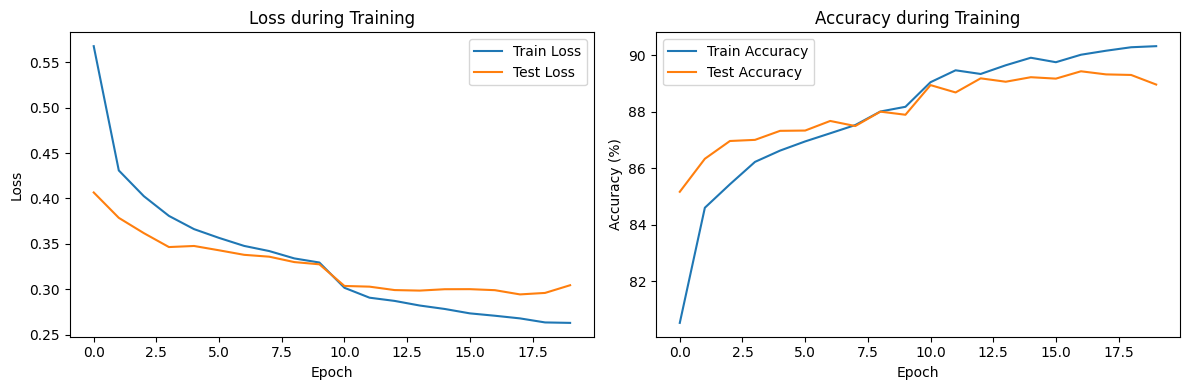

In [ ]:
# 6. Визуализация результатов
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during Training')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy during Training')

plt.tight_layout()
plt.show()



In [21]:
# 7. Сохранение модели
if final_test_acc >= 88.0:
    torch.save(model.state_dict(), 'fashion_mnist_model.pth')
    print("Модель сохранена как 'fashion_mnist_model.pth'")

Модель сохранена как 'fashion_mnist_model.pth'
